### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/My Drive/CNN_assignment"

'Skin cancer ISIC The International Skin Imaging Collaboration'


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [6]:
!ls "/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration"

Test  Train


In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note: use seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: make sure to resize images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7153 files belonging to 9 classes.
Using 5723 files for training.


In [10]:
## Write your validation dataset here
## Note: use seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note: make sure to resize images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7153 files belonging to 9 classes.
Using 1430 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# Cclass names are found in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [12]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [13]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


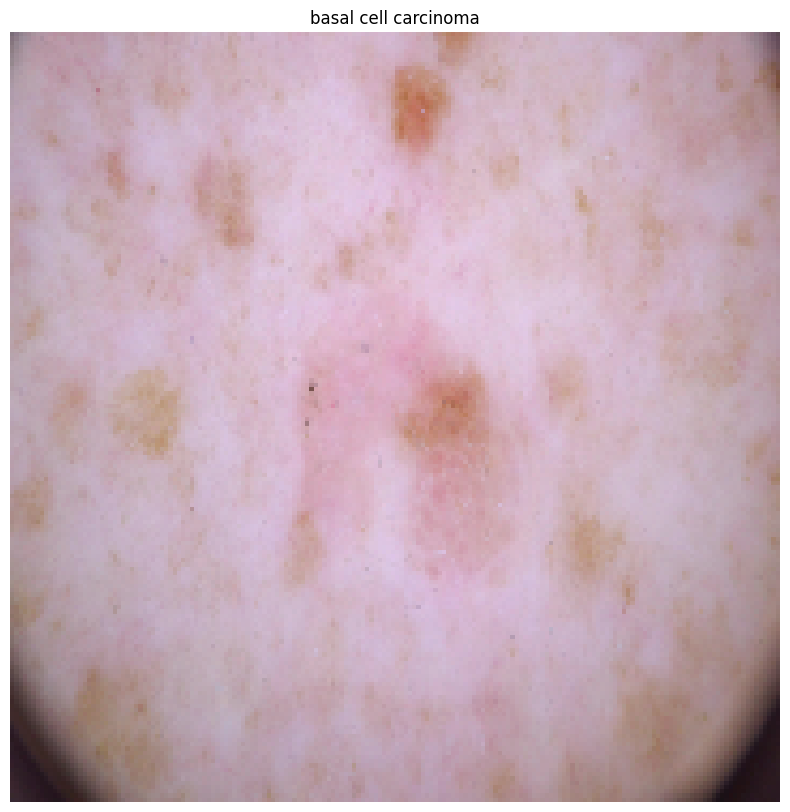

In [14]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")


### Visualize the data
#### To do: create a code to visualize one instance of all the nine classes present in the dataset

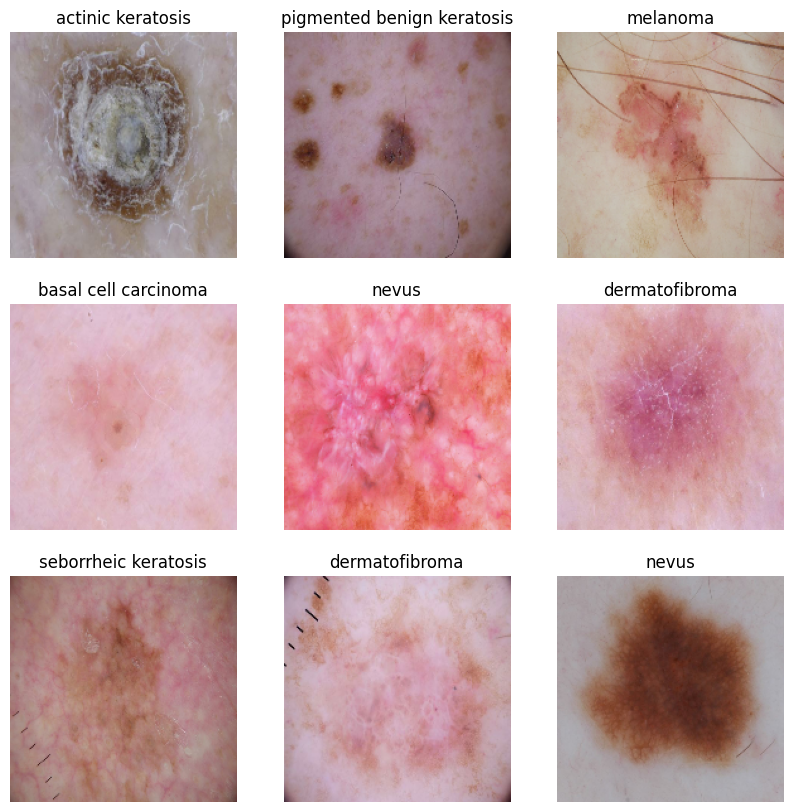

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

In [16]:
#print(type(train_ds))
#print(len(train_ds)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### To do: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
   layers.Conv2D(32, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(256, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        36928     
                                                        

In [20]:
### To do: choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
179/179 [==============================] - 67s 147ms/step - loss: 1.9682 - accuracy: 0.2293 - val_loss: 1.6273 - val_accuracy: 0.4084
Epoch 2/20
179/179 [==============================] - 14s 77ms/step - loss: 1.5779 - accuracy: 0.4059 - val_loss: 1.4416 - val_accuracy: 0.4615
Epoch 3/20
179/179 [==============================] - 14s 77ms/step - loss: 1.3768 - accuracy: 0.4894 - val_loss: 1.2253 - val_accuracy: 0.5448
Epoch 4/20
179/179 [==============================] - 14s 78ms/step - loss: 1.1331 - accuracy: 0.5901 - val_loss: 1.1021 - val_accuracy: 0.5958
Epoch 5/20
179/179 [==============================] - 14s 80ms/step - loss: 0.8136 - accuracy: 0.7024 - val_loss: 0.9381 - val_accuracy: 0.6895
Epoch 6/20
179/179 [==============================] - 14s 80ms/step - loss: 0.6165 - accuracy: 0.7818 - val_loss: 0.8153 - val_accuracy: 0.7322
Epoch 7/20
179/179 [==============================] - 15s 81ms/step - loss: 0.4086 - accuracy: 0.8588 - val_loss: 0.7861 - val_accuracy

### Visualizing training results

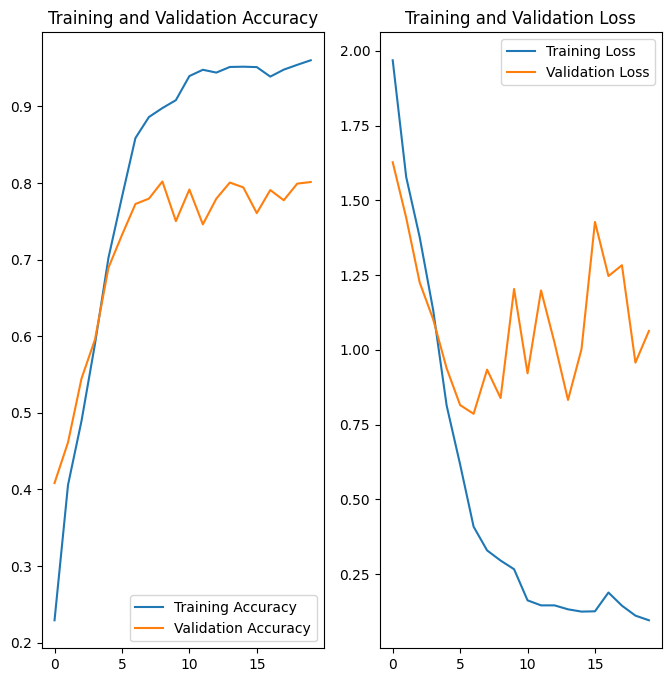

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### To do: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

##### finding ::
We can see that model train accuracy is 90 % while validation accuracy is around 74%. So model is overfitted.

### Chose an appropriate data augmentation strategy to resolve underfitting/overfitting


In [23]:
# To do: after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

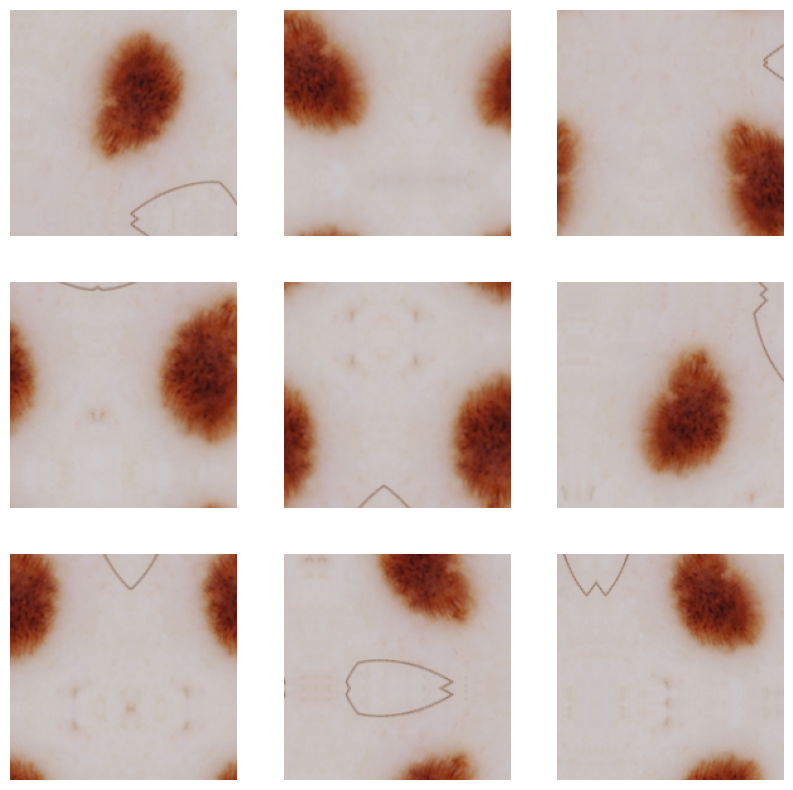

In [24]:
# To do: visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model Building & training on the augmented data

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
179/179 [==============================] - 25s 114ms/step - loss: 2.0982 - accuracy: 0.1854 - val_loss: 1.8843 - val_accuracy: 0.2510
Epoch 2/20
179/179 [==============================] - 20s 111ms/step - loss: 1.8706 - accuracy: 0.2569 - val_loss: 1.8964 - val_accuracy: 0.2448
Epoch 3/20
179/179 [==============================] - 20s 113ms/step - loss: 1.7558 - accuracy: 0.3247 - val_loss: 1.9255 - val_accuracy: 0.3007
Epoch 4/20
179/179 [==============================] - 20s 111ms/step - loss: 1.6887 - accuracy: 0.3524 - val_loss: 1.6364 - val_accuracy: 0.3615
Epoch 5/20
179/179 [==============================] - 20s 110ms/step - loss: 1.6223 - accuracy: 0.3743 - val_loss: 1.5744 - val_accuracy: 0.4021
Epoch 6/20
179/179 [==============================] - 20s 111ms/step - loss: 1.5807 - accuracy: 0.3925 - val_loss: 1.5007 - val_accuracy: 0.4147
Epoch 7/20
179/179 [==============================] - 20s 111ms/step - loss: 1.5480 - accuracy: 0.4064 - val_loss: 1.5135 - val_ac

### Visualizing the results

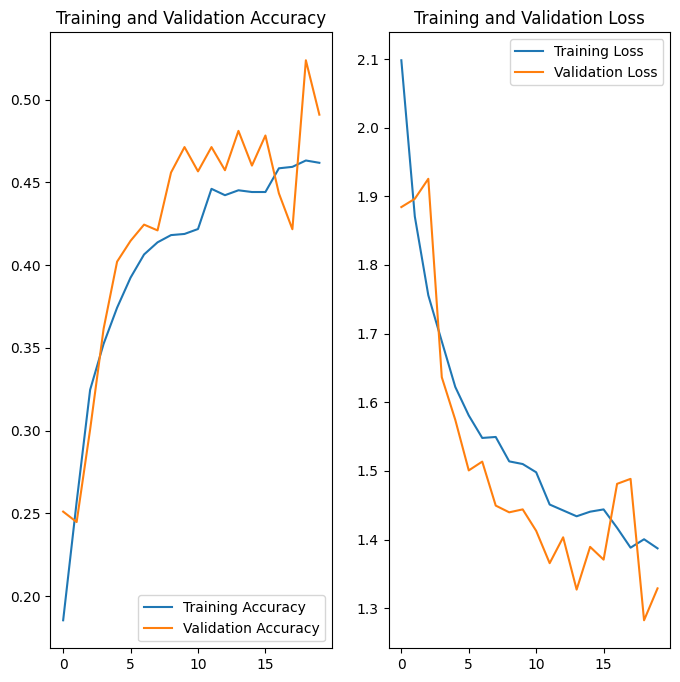

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
#Finding:
# we can see the model is underfit here. Accuracy has dropped a lot.


In [30]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
val_dir = os.path.join('/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 64
IMG_SHAPE = 180

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 7153 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [32]:
# Create a CNN model
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Import layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

#2D convolution layer (e.g. spatial convolution over images).
model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Dropout(0.2))

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))

model.add(Dropout(0.2))
#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())

#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
model.add(Dense(256, activation='relu'))

#Just your regular densely-connected NN layer.
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=20
)

Epoch 1/20
112/112 [==============================] - 270s 2s/step - loss: 1.9526 - accuracy: 0.2740 - val_loss: 1.9313 - val_accuracy: 0.3390
Epoch 2/20
112/112 [==============================] - 129s 1s/step - loss: 1.5151 - accuracy: 0.4226 - val_loss: 1.7954 - val_accuracy: 0.3559
Epoch 3/20
112/112 [==============================] - 131s 1s/step - loss: 1.4460 - accuracy: 0.4485 - val_loss: 1.8368 - val_accuracy: 0.3729
Epoch 4/20
112/112 [==============================] - 132s 1s/step - loss: 1.3848 - accuracy: 0.4685 - val_loss: 1.9291 - val_accuracy: 0.3390
Epoch 5/20
112/112 [==============================] - 130s 1s/step - loss: 1.3346 - accuracy: 0.4822 - val_loss: 1.8287 - val_accuracy: 0.4322
Epoch 6/20
112/112 [==============================] - 130s 1s/step - loss: 1.3260 - accuracy: 0.4840 - val_loss: 1.8124 - val_accuracy: 0.3475
Epoch 7/20
112/112 [==============================] - 130s 1s/step - loss: 1.2923 - accuracy: 0.5019 - val_loss: 1.9516 - val_accuracy: 0.3305

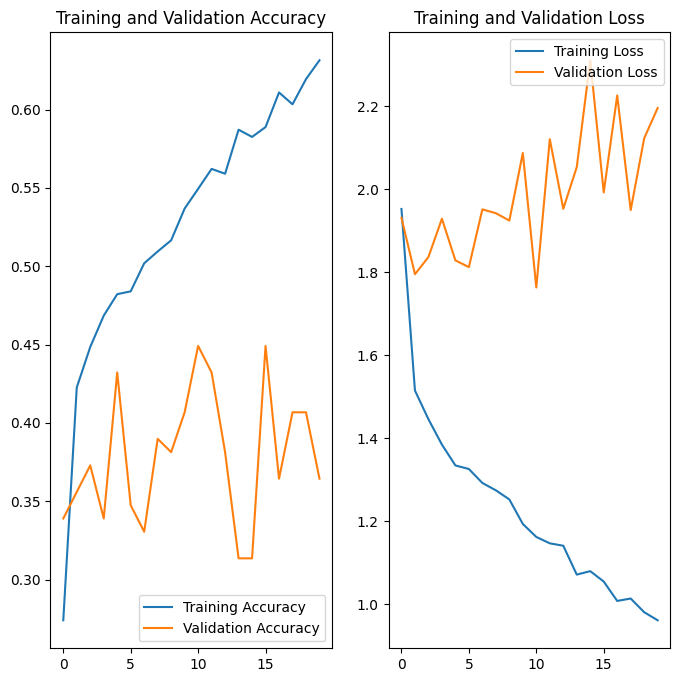

In [33]:
import matplotlib.pyplot as plt
epochs=20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### To do: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


In [34]:
# We see that model is under fitted.

#### **To do:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [35]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [36]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/My Drive/CNN_assignment/Skin ca...,squamous cell carcinoma
1,/content/drive/My Drive/CNN_assignment/Skin ca...,squamous cell carcinoma
2,/content/drive/My Drive/CNN_assignment/Skin ca...,squamous cell carcinoma
3,/content/drive/My Drive/CNN_assignment/Skin ca...,squamous cell carcinoma
4,/content/drive/My Drive/CNN_assignment/Skin ca...,squamous cell carcinoma
...,...,...
2234,/content/drive/My Drive/CNN_assignment/Skin ca...,basal cell carcinoma
2235,/content/drive/My Drive/CNN_assignment/Skin ca...,basal cell carcinoma
2236,/content/drive/My Drive/CNN_assignment/Skin ca...,basal cell carcinoma
2237,/content/drive/My Drive/CNN_assignment/Skin ca...,basal cell carcinoma


<Figure size 1000x1000 with 0 Axes>

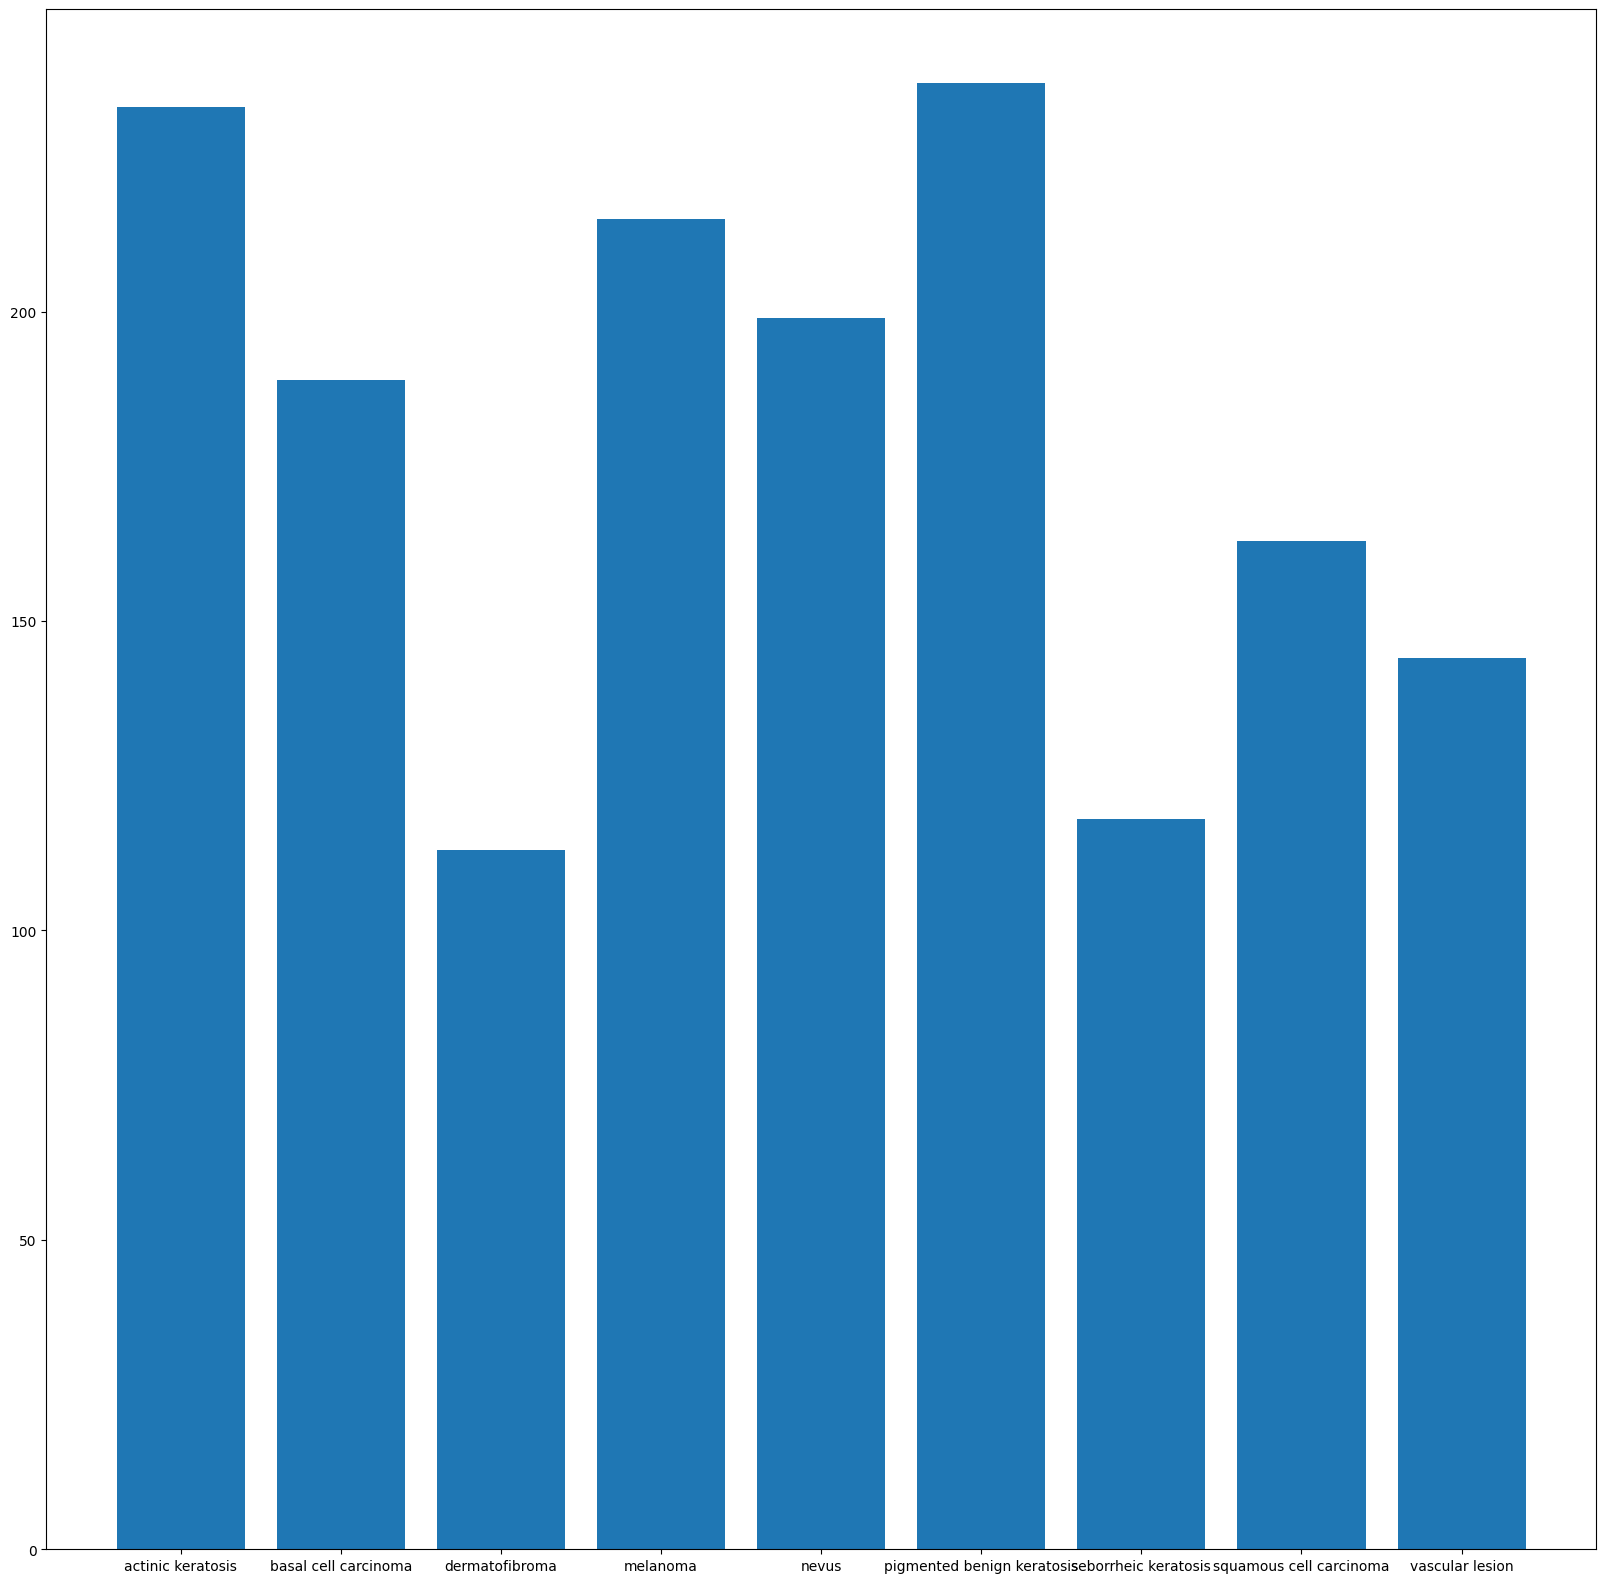

In [37]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **To do:** Write your findings here:
#### - Which class has the least number of samples?
#####  Ans : dermatofibroma
#### - Which classes dominate the data in terms proportionate number of samples?
##### Ans: melanoma


#### **To do:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

In [39]:
#https://github.com/mdbloice/Augmentor
#https://github.com/mdbloice/Augmentor
datapath=r'/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
p.sample(300)
p.process()


Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAEB4E52980>: 100%|██████████| 300/300 [00:14<00:00, 20.75 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAEB4E8B0D0>: 100%|██████████| 114/114 [00:05<00:00, 19.67 Samples/s]


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
path_to_training_dataset="/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

#import Augmentor
for i in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset + i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAEB4EFCD60>: 100%|██████████| 500/500 [00:21<00:00, 22.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAEB4E145B0>: 100%|██████████| 500/500 [00:23<00:00, 21.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAEB4DE7F10>: 100%|██████████| 500/500 [00:22<00:00, 22.46 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x7FAEC05B43A0>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAEB46A4670>: 100%|██████████| 500/500 [01:20<00:00,  6.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAEB4EFF7C0>: 100%|██████████| 500/500 [00:19<00:00, 26.13 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAF38B8F5B0>: 100%|██████████| 500/500 [00:38<00:00, 12.84 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FAF341E6110>: 100%|██████████| 500/500 [00:19<00:00, 25.63 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAEB4E8BAF0>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9828


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026319.jpg_68a00848-9b29-4c02-bba2-b59fccc16a31.jpg',
 '/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029573.jpg_25215cbe-9a2e-482b-8a77-4005799eda53.jpg',
 '/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026138.jpg_92a83bf5-c136-4eea-94d8-db0858f3f831.jpg',
 '/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032154.jpg_7fb3d32a-684d-4d3c-bbf9-f4db111118ae.jpg',
 '/content/drive/My Drive/CNN_assignment/Skin cancer ISIC The Intern

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [44]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2])

In [46]:
new_df['Label'].value_counts()

Label
actinic keratosis             1942
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
dermatofibroma                1095
seborrheic keratosis          1077
Name: count, dtype: int64

Class=7, n=1181 (9.787%)
Class=5, n=1462 (12.116%)
Class=4, n=1357 (11.246%)
Class=2, n=1095 (9.074%)
Class=3, n=1438 (11.917%)
Class=0, n=1942 (16.093%)
Class=8, n=1139 (9.439%)
Class=6, n=1077 (8.925%)
Class=1, n=1376 (11.403%)


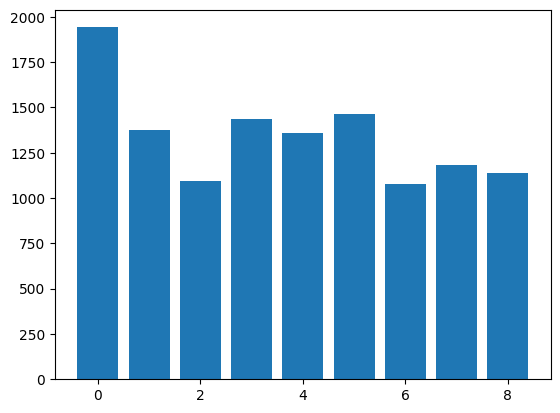

In [47]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = new_df['Path'], new_df['Label']
 #label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
#plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()



So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **To do**: Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

#### **To do:** Create a training dataset

In [49]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12067 files belonging to 9 classes.
Using 9654 files for training.


#### **To do:** Create a validation dataset

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12067 files belonging to 9 classes.
Using 2413 files for validation.


#### **To do:** Create your model (make sure to include normalization)

In [51]:
from tensorflow.keras.layers import BatchNormalization
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(3,3),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

#### **To do:** Compile your model (Choose optimizer and loss function appropriately)

In [52]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **To do:**  Train your model

In [53]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
302/302 [==============================] - 117s 161ms/step - loss: 2.1969 - accuracy: 0.1616 - val_loss: 2.0918 - val_accuracy: 0.2155
Epoch 2/30
302/302 [==============================] - 32s 106ms/step - loss: 1.8320 - accuracy: 0.2949 - val_loss: 1.6395 - val_accuracy: 0.3523
Epoch 3/30
302/302 [==============================] - 32s 105ms/step - loss: 1.5673 - accuracy: 0.3940 - val_loss: 1.4541 - val_accuracy: 0.4600
Epoch 4/30
302/302 [==============================] - 31s 104ms/step - loss: 1.2337 - accuracy: 0.5407 - val_loss: 1.1063 - val_accuracy: 0.5852
Epoch 5/30
302/302 [==============================] - 32s 104ms/step - loss: 0.8637 - accuracy: 0.6866 - val_loss: 0.8383 - val_accuracy: 0.7161
Epoch 6/30
302/302 [==============================] - 33s 108ms/step - loss: 0.6030 - accuracy: 0.7792 - val_loss: 0.6209 - val_accuracy: 0.7857
Epoch 7/30
302/302 [==============================] - 32s 105ms/step - loss: 0.4650 - accuracy: 0.8284 - val_loss: 0.5891 - val_a

#### **To do:**  Visualize the model results

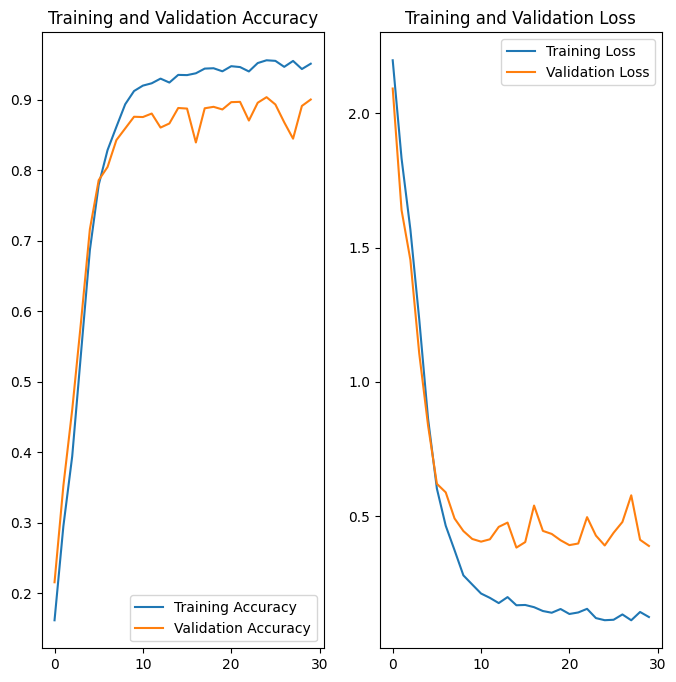

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **To do:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [55]:
# We see that model performance has been improved after generating the images.
# The rebalancing of the class played a significant role in mitigating overfitting of the data, resulting in a decrease in loss. However, the approach also resulted in a notable increase in accuracy.

# In the beginning, we experimented without utilizing the ImageDataGenerator, which led to a high degree of overfitting in the data. Subsequently, we implemented dropout and the ImageDataGenerator, which helped to reduce overfitting.
